# Sheeps and Goats classifier
Sheep, goat, horse, cattle and camel are Five treasures of Mongolian. Usually, people have a little hard time identifying goat and sheep. This would be an interesting task to let computer do it. In order to train my Neural Network, I downloaded Goat and Sheep images from Internet.

Download images: 
 - Chrome extension: ImageDownloader. This is a great tool to batch download images.
 - https://pixabay.com/ : I found these images are free and batch downloadable with ImageDownloader.
 - Manually clear some of pictures that do not make sense; like cartoon pics.
 - I ended up with Goats: 230 pics, Sheeps: 180 pics

#### I will do:
 - Image data preparation
 - Build a basic Convnet Img Classifier and see the accuracy
 - Data Augmentation to improve accuracy
 - Adapt pre-trained Imagenet Model (VGG16) to improve accuracy
By doing above steps, the prediction accuracy should keep improving.


#### Requirements:
 - pip install Keras
 - pip intall pillows
 - Install h5py. 'Pip install h5py' did not work for me on windows, So I downloaded [h5py wheel file](https://pypi.python.org/pypi/h5py/2.7.0rc2) and it worked. Your need to install ["Microsoft Visual C++ Build Tools"](http://landinghub.visualstudio.com/visual-cpp-build-tools) first. 

#### Notes:
 - Datasets total image numbers have to be even number, otherwise the code gives an error.
 - Highly recommend to use GPU. Otherwise, the last part of fine-tuning codes are so slow. I have to try to adjust n_epoch a few times to run through all the codes.
 - I need to keep improving this code:
   - increase dataset size
   - need to correct labels; I felt like some of labels are not correct.
   - Use GPU

## Step 0: Data Preparation
In order to run keras, the data has to be structured according the requirement.
 - create directories for Keras 
 - reshape image data
 - This part of work just need to run once. Repeated running will give errors

In [2]:
%pwd

'C:\\Udacity\\DLNF\\DL-Projects\\wk6-image-classifier'

In [1]:
%matplotlib inline
import os, sys
import numpy as np
from matplotlib import pyplot as plt

#### Create directories 

In [2]:
current_dir = os.getcwd()
HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'

In [5]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir train
%cd train
%mkdir sheeps
%mkdir goats
%cd ..
%mkdir valid
%cd valid
%mkdir sheeps
%mkdir goats
%cd ..


C:\Udacity\DLNF\DL-Projects\wk6-image-classifier\data
C:\Udacity\DLNF\DL-Projects\wk6-image-classifier\data\train


A subdirectory or file train already exists.
A subdirectory or file sheeps already exists.


C:\Udacity\DLNF\DL-Projects\wk6-image-classifier\data


A subdirectory or file goats already exists.


C:\Udacity\DLNF\DL-Projects\wk6-image-classifier\data\valid


A subdirectory or file valid already exists.
A subdirectory or file sheeps already exists.


C:\Udacity\DLNF\DL-Projects\wk6-image-classifier\data


A subdirectory or file goats already exists.


#### Rearrange images

In [22]:
from glob import glob
#from shutil import copyfile

In [30]:
g = glob('rawdata/sheeps/*.jpg')
indx = 0
for ind, filename in enumerate(g):
    try:
        os.rename(filename, "train/sheeps/sheep_{0}.jpg".format(ind))
        indx += 1
    except OSError as e:
        print("Something is wrong!!",e)
print(indx)

177


In [47]:
g = glob('rawdata/sheeps/*.png')
for ind, filename in enumerate(g):
    try:
        os.rename(filename, "train/sheeps/sheep_{0}.png".format(indx+ind))
    except OSError as e:
        print("Something is wrong!!",e)

In [48]:
g = glob('rawdata/goats/*.jpg')
indx = 0
for ind, filename in enumerate(g):
    try:
        os.rename(filename, "train/goats/goat_{0}.jpg".format(ind))
        indx += 1
    except OSError as e:
        print("Something is wrong!!",e)
print(indx)

229


In [49]:
g = glob('rawdata/goats/*.png')
for ind, filename in enumerate(g):
    try:
        os.rename(filename, "train/goats/goat_{0}.png".format(indx+ind))
    except OSError as e:
        print("Something is wrong!!",e)

#### create validation data

In [ ]:
%cd train/goats
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(60): 
    os.rename(shuf[i], '../../valid/goats/' + shuf[i])

%cd ../..

In [59]:
%cd train/sheeps
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(40): 
    os.rename(shuf[i], '../../valid/sheeps/' + shuf[i])
%cd ../..

C:\Udacity\DLNF\DL-Projects\wk6-image-classifier\data\train\sheeps
C:\Udacity\DLNF\DL-Projects\wk6-image-classifier\data


In [7]:
%cd ..

C:\Udacity\DLNF\DL-Projects\wk6-image-classifier


## Import data
This step has to be done before running models everytime.

I have generated following data from above steps:
- Train -- Goats: 170 pics, Sheeps: 140 pics
- Valid -- Goats: 60 pics, Sheeps: 40 pics

In [2]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers

import h5py
from PIL import Image

Using TensorFlow backend.


In [3]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/valid'

### Let's plot a few pictures to see what it is like

In [5]:
# This function is for plotting images
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [6]:
datagen = ImageDataGenerator()

batches = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=4,
        class_mode='binary')

Found 310 images belonging to 2 classes.


In [7]:
imgs,labels = next(batches)

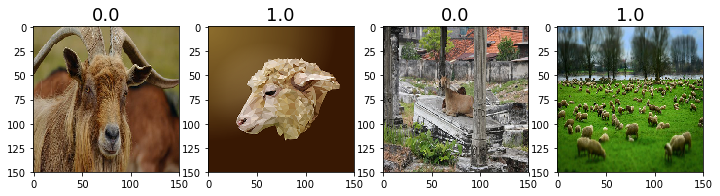

In [8]:
plots(imgs, titles=labels)

### Generating Data

In [4]:
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=4,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=4,
        class_mode='binary')

Found 310 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## Step 1. My first Convnet

#### Model Creation

In [5]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#### Model Training

In [10]:
nb_epoch = 15 #30
nb_train_samples = 310
nb_validation_samples = 100

In [38]:
model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/15
310/310 [==============================] - 19s - loss: 0.7348 - acc: 0.5258 - val_loss: 0.6860 - val_acc: 0.6000

In [40]:
model.save_weights('models/basic_cnn_15_epochs.h5')

In [39]:
model.evaluate_generator(validation_generator, nb_validation_samples)

[2.4724220679700375, 0.62]

#### I got 62% accuracy in this step!!!!!

## Step 2. Augmentation
Since I have very small size data, augmentation is critical. 

In [7]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,        # normalize pixel values to [0,1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,       # randomly applies shearing transformation
    zoom_range=0.2,        # randomly applies shearing transformation
    fill_mode='nearest',
    horizontal_flip=True)  # randomly flip the images

#### Following code will generate augmented sample images in 'review' folder

In [23]:
img = load_img('data/train/goats/goat_27.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train_datagen_augmented.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='goat', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [8]:
# same code as before
train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='binary')

Found 310 images belonging to 2 classes.


In [13]:
model.fit_generator(
        train_generator_augmented,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/15
310/310 [==============================] - 14s - loss: 0.6563 - acc: 0.6387 - val_loss: 0.6869 - val_acc: 0.5500

In [14]:
model.save_weights('models/augmented_15_epochs.h5')

In [15]:
model.evaluate_generator(validation_generator, nb_validation_samples)

[0.68109502971172331, 0.66000000000000003]

#### Accuracy is 66%, improved little!!!!!

## Step 3. Fine-tuning

### 3.1 VGG16 Model

In [16]:
model_vgg = Sequential()
model_vgg.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height,3)))
model_vgg.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

### 3.2 Load VGG16 weights

In [17]:
f = h5py.File('models/vgg16_weights.h5')
for k in range(f.attrs['nb_layers']):
    if k >= len(model_vgg.layers) - 1:
        # we don't look at the last two layers in the savefile (fully-connected and activation)
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    layer = model_vgg.layers[k]

    if layer.__class__.__name__ in ['Convolution1D', 'Convolution2D', 'Convolution3D', 'AtrousConvolution2D']:
        weights[0] = np.transpose(weights[0], (2, 3, 1, 0))

    layer.set_weights(weights)

f.close()

### 3.3 Use VGG16 model to process samples

In [18]:
train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode=None,
        shuffle=False)

Found 310 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [19]:
bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck, nb_train_samples)
np.save(open('models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [20]:
bottleneck_features_validation = model_vgg.predict_generator(validation_generator_bottleneck, nb_validation_samples)
np.save(open('models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [21]:
train_data = np.load(open('models/bottleneck_features_train.npy', 'rb'))
# image numbers have to be even, otherwise occur error
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load(open('models/bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [22]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
nb_epoch=20
model_top.fit(train_data, train_labels,
          nb_epoch=nb_epoch, batch_size=16,
          validation_data=(validation_data, validation_labels))

Train on 310 samples, validate on 100 samples
Epoch 1/20
310/310 [==============================] - 1s - loss: 2.3821 - acc: 0.5452 - val_loss: 0.8087 - val_acc: 0.5900

In [25]:
model_top.save_weights('models/bottleneck_20_epochs.h5')

In [24]:
model_top.evaluate(validation_data, validation_labels)

 32/100 [========>.....................] - ETA: 0s

[1.4994403362274169, 0.68999999999999995]

#### This time, the accuracy is 69%. Improved little !!!!

### 3.4 Fine-tuning the top layers of a a pre-trained network

In [26]:
model_vgg = Sequential()
model_vgg.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height,3)))
model_vgg.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model_vgg.add(ZeroPadding2D((1, 1)))
model_vgg.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [28]:
f = h5py.File('models/vgg16_weights.h5')
for k in range(f.attrs['nb_layers']):
    if k >= len(model_vgg.layers) - 1:
        # we don't look at the last two layers in the savefile (fully-connected and activation)
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    layer = model_vgg.layers[k]

    if layer.__class__.__name__ in ['Convolution1D', 'Convolution2D', 'Convolution3D', 'AtrousConvolution2D']:
        weights[0] = np.transpose(weights[0], (2, 3, 1, 0))

    layer.set_weights(weights)

f.close()

In [29]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.load_weights('models/bottleneck_20_epochs.h5')

model_vgg.add(top_model)

In [30]:
for layer in model_vgg.layers[:25]:
    layer.trainable = False

In [31]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model_vgg.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [32]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=16,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=16,
        class_mode='binary')

Found 310 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [33]:
# fine-tune the model
model_vgg.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/20
310/310 [==============================] - 183s - loss: 0.4039 - acc: 0.8774 - val_loss: 0.9836 - val_acc: 0.7600

KeyboardInterrupt: 

#### I interrupt it intentionally after 10 Epoch. It just ran too slow.  And I can see that the validation accuracy is around 75% from above records. 

In [34]:
model_vgg.evaluate_generator(validation_generator, nb_validation_samples)
#Image.open('data/train/sheeps/sheep_2.jpg')

[1.1126276911795139, 0.75]

#### The Accuracy is up to 75% now.  We start from 62%, then 65%, 69% and 75% in the end. It is good because it is making progress. I will keep working on it.